In [69]:
import os
from os.path import join
import glob

# Directory containing results
results_dir = r"C:\insilico_exps\BigGAN_hyperparam_tune\alexnet"
import re
import pandas as pd
import pickle as pkl
# Define regex pattern to extract parameters
pattern = r"Evol_results_BigGAN_(?P<gan_type>INet|EcoSet)(_sigma(?P<sigma>[\d\.]+))?_resnet50_linf8_(?P<layer>\w+)_ch(?P<channel>\d+)_rep(?P<rep>\d+)\.pkl"


pkl_files = glob.glob(join(results_dir, "Evol_results_BigGAN_INet*.pkl"))
# Create empty lists to store parameters
params = []

# Extract parameters from each filename
for pkl_file in pkl_files:
    filename = os.path.basename(pkl_file)
    match = re.match(pattern, filename)
    if match:
        with open(pkl_file, 'rb') as f:
            data = pkl.load(f)
        best_img = data["best_imgs"][-1]
        last_gen_score = data['scores'][data['generations']==99]
        last_mean_score = last_gen_score.mean()
        param_dict = match.groupdict()
        param_dict['filename'] = filename
        param_dict['filepath'] = pkl_file
        # Convert numeric fields

        param_dict['sigma'] = float(param_dict['sigma']) if param_dict['sigma'] else 0.06  # default sigma
        param_dict['channel'] = int(param_dict['channel'])
        param_dict['rep'] = int(param_dict['rep'])
        param_dict['last_mean_score'] = last_mean_score
        param_dict['best_img'] = best_img
        params.append(param_dict)
    else:
        print(f"No match found for {filename}")

# Create pandas DataFrame
df = pd.DataFrame(params)
# Get all pkl files

In [70]:
# Get max score for each layer and unit
max_scores = df.groupby(["layer", "channel"])["last_mean_score"].transform("max")
# Normalize scores by dividing by max score for that layer/unit
df["normalized_score"] = df["last_mean_score"] / max_scores
# Group and aggregate the normalized scores
df.groupby(["layer", "sigma"]).agg({"normalized_score": "mean"})

normalized_score
layer sigma                  
conv5 0.01           0.229531
      0.02           0.317404
      0.04           0.399438
      0.06           0.454305
      0.08           0.598391
      0.10           0.767334
      0.20           0.706842
      0.40           0.747227
      0.80           0.312650
      1.00           0.243042
      2.00           0.053234
      3.00           0.041859
fc6   0.01           0.281264
      0.02           0.469456
      0.04           0.511288
      0.06           0.584601
      0.08           0.591502
      0.10           0.663579
      0.20           0.806786
      0.40           0.833790
      0.80           0.800319
      1.00           0.630159
      2.00           0.436141
      3.00           0.393828
fc7   0.01           0.201010
      0.02           0.331275
      0.04           0.475880
      0.06           0.562072
      0.08           0.580357
      0.10           0.688231
      0.20           0.760314
      0.40           0.911012
      0.80           0.701939
      1.00           0.552114
      2.00           0.214322
      3.00           0.154055

In [71]:
df.groupby(["layer", "sigma"]).agg({"last_mean_score": "mean"})#.reset_index()

last_mean_score
layer sigma                 
conv5 0.01         10.900144
      0.02         14.524310
      0.04         17.792889
      0.06         22.423422
      0.08         23.087551
      0.10         36.277519
      0.20         28.517694
      0.40         31.238220
      0.80         12.290860
      1.00          8.992861
      2.00          2.262329
      3.00          1.458152
fc6   0.01         10.091445
      0.02         17.570875
      0.04         18.118980
      0.06         22.014954
      0.08         22.033073
      0.10         24.209475
      0.20         30.099434
      0.40         31.619005
      0.80         31.773443
      1.00         24.505968
      2.00         16.798960
      3.00         15.481124
fc7   0.01          7.249851
      0.02         11.048117
      0.04         15.830254
      0.06         18.876644
      0.08         19.421055
      0.10         22.907675
      0.20         26.098520
      0.40         30.954920
      0.80         23.451763
      1.00         19.916603
      2.00          7.806861
      3.00          5.630904

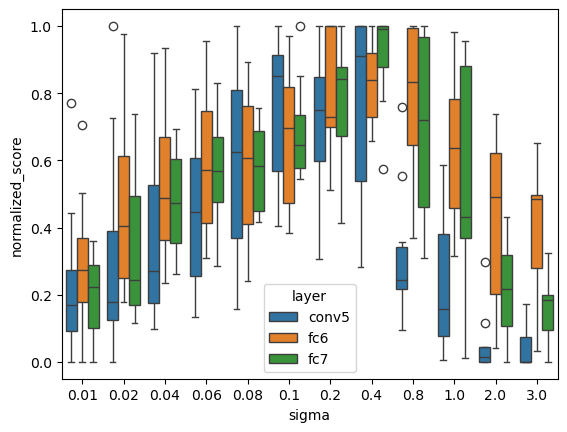

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.boxplot(x='sigma', y='last_mean_score', data=df, hue="layer")# normalized_score
sns.boxplot(x='sigma', y='normalized_score', data=df, hue="layer")# normalized_score
plt.show()

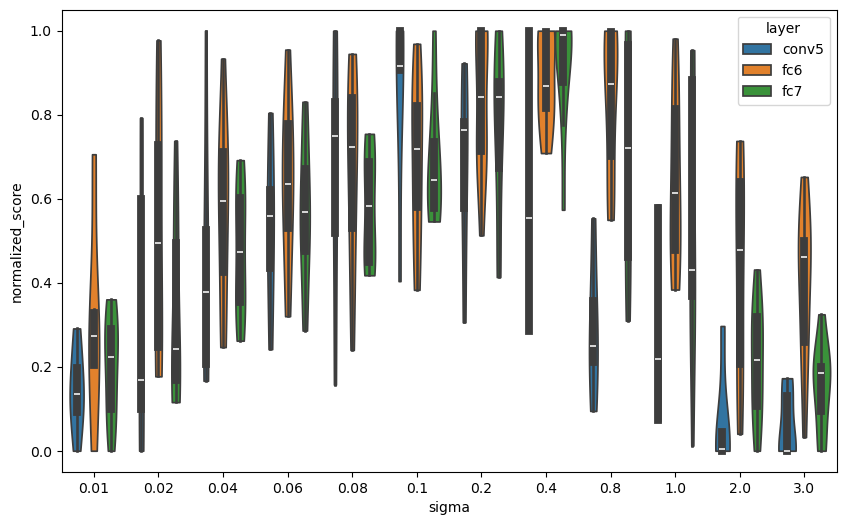

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# sns.stripplot(x='sigma', y='last_mean_score', data=df, hue="layer")
sns.violinplot(x='sigma', y='normalized_score', data=df, hue="layer", cut=0) # last_mean_score
plt.show()

In [48]:
best_imgs[0].shape

torch.Size([3, 256, 256])

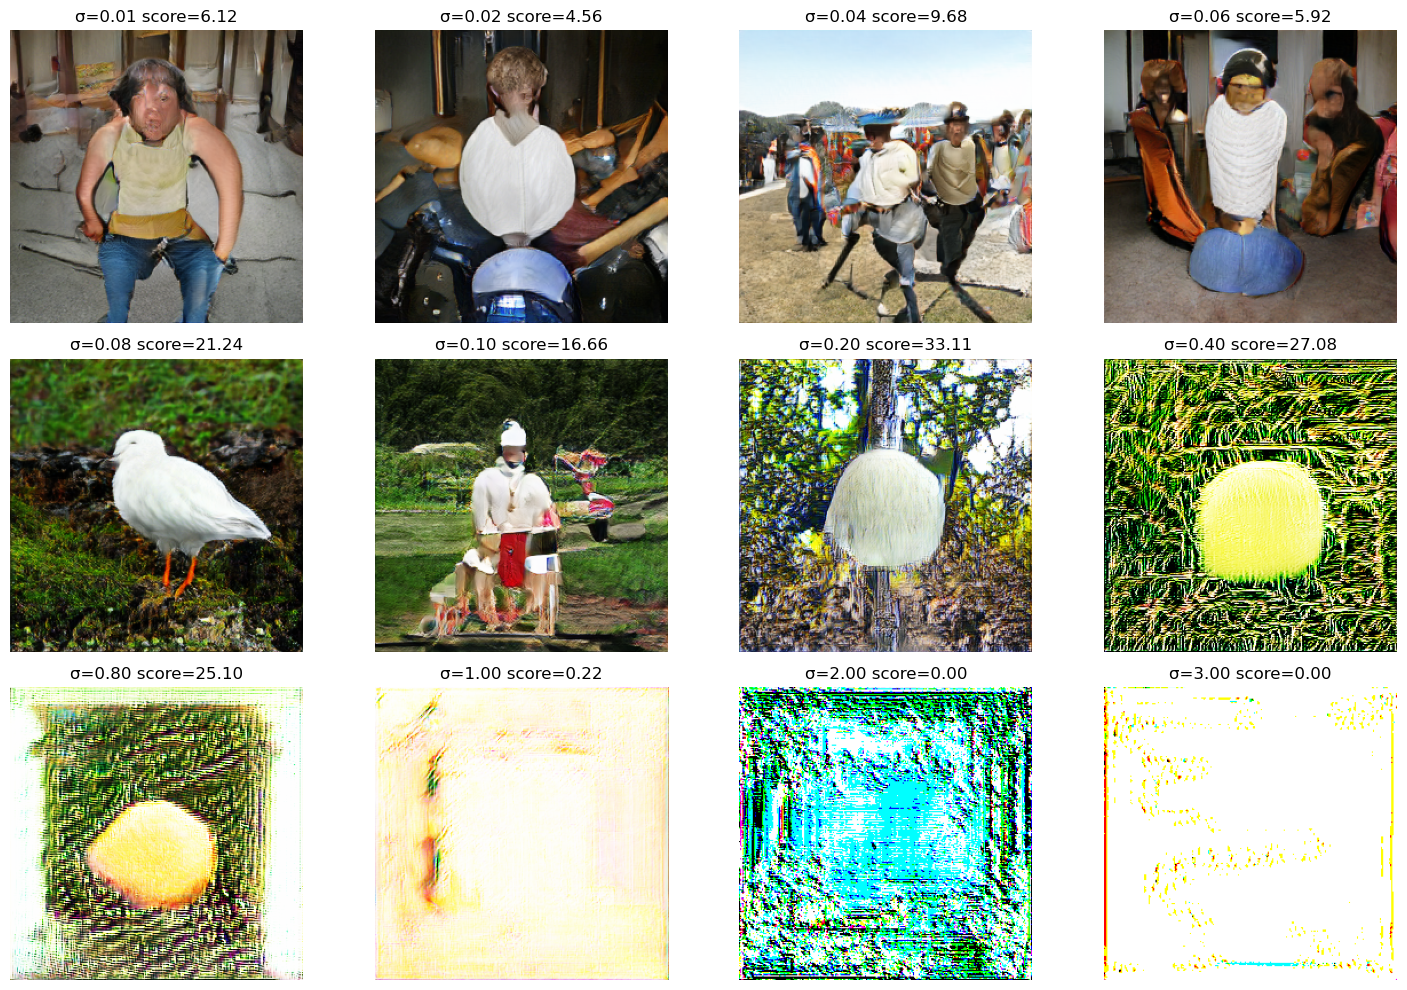

In [76]:
# find best image for one layer and unit and display them
df_subset = df.query("layer == 'conv5' and channel == 6").sort_values(by="sigma", ascending=True)
best_imgs = df_subset.best_img.values

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, img in enumerate(best_imgs):
    if i < len(axes):
        axes[i].imshow(img.permute(1,2,0).numpy())
        axes[i].axis('off')
        axes[i].set_title(f'σ={df_subset.iloc[i].sigma:.2f} score={df_subset.iloc[i].last_mean_score:.2f}')

plt.tight_layout()
plt.show()